The primary goal of this data preprocessing is to prepare the dataset for a Market Basket Analysis (MBA) at the category level. The process involved cleaning, validating, and merging multiple datasets to create a final transactional table suitable for MBA in Tableau or Python.

**Main steps performed:**

1.  **Initial inspection** – Checked each table for basic structure: data types, missing values, duplicates, shape, and size.

2. **Target column selection** – Identified the columns required for MBA on the category level: `order_id`, `product_id`, and `product_category_name_english`.

3. **Removing duplicate product–order pairs** – Modified the `orders` table so that each (`order_id`, `product_id`) combination appears only once, added `quantity` column.

4. **Handling missing categories** – Dropped rows in the `products` table with no value in `product_category_name`.

5. **Fixing translation mismatches** – Resolved missing matches in the translation table by identifying and adding English translations for two product categories absent from the table.

6. **Merging translations** – Added the English category names to the `products` table via the translation table.

7. **Final dataset creation** – Merged the cleaned `products` table with the cleaned `orders` table on `product_id`, keeping only `order_id`, `product_id`, and `product_category_name_english`.

In [3]:
#setup environment
import pandas as pd
import kagglehub

In [4]:
#load data
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
#print("Path to dataset files:", path)
orders_raw = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
products_raw = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
products_transl_raw = pd.read_csv("/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv")

## Orders

In [5]:
orders_raw.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14




*   **order_id** - order unique identifier
*   **order_item_id** - sequential number identifying number of items included in the same order
*   **product_id**  - product unique identifier
*   **seller_id** - seller unique identifier
*   **shipping_limit_date** - shows the seller shipping limit date for handling the order over to the logistic partner
*   **price** - item price
*   **freight_value** - item freight value item (if an order has more than one item the freight value is splitted between items)

In [6]:
orders_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


There are is no missing values. Now we will see if there are any duplicates

In [7]:
# Check if all columns are exactly the same in more than one row
orders_raw.duplicated().sum()   # ---> 0 orders

# Check if the same product is repeated in the same order
#orders_raw.duplicated(subset=['order_id', 'product_id']).sum()  #10225 combinations order_id + product_id are duplicates
orders_raw[orders_raw.duplicated(subset=['order_id', 'product_id'], keep=False)]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
...,...,...,...,...,...,...,...
112635,fff8287bbae429a99bb7e8c21d151c41,2,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-03-27 12:29:22,180.00,48.14
112640,fffb9224b6fc7c43ebb0904318b10b5f,1,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19


This table does not contain a *quantity* column. Instead, each occurrence of a product in an order is represented as a separate row — even if the same product appears multiple times within that order.

In [8]:
# Append Quantity col
orders = orders_raw
orders.insert(7, 'quantity',1)
orders.shape

(112650, 8)

In [9]:
orders = orders.groupby(by=['order_id', 'product_id'], as_index = False).agg(quantity=('quantity', 'sum'))
orders.shape

(102425, 3)

Let's examine how the table changes after aggregation, using a single order as an example

In [10]:
orders_raw.loc[orders_raw.order_id =='00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,quantity
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,1


In [11]:
orders.loc[orders.order_id =='00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,product_id,quantity
31,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,3


In [12]:
print(len(orders['order_id'].unique()))

98666


For **product-level MBA**, products purchased very rarely can add noise without contributing meaningful co-occurrence patterns. Setting a minimum purchase frequency *threshold* helps focus the analysis on items with sufficient support. In this dataset (~99.7K unique orders), a *threshold* of 20 purchases means each product appears in at least ~0.02% of all orders — a reasonable balance between variety and statistical strength.

`orders`

---
For **category-level MBA**, all products are retained. Even rare products still contribute to their category's counts, and dropping them could weaken the representation of certain categories.

`orders_cut`



In [13]:
# Counts how often the product was it someone's basket without taking into account the quantity
item_freq = orders['product_id'].value_counts()
item_freq

,count
product_id,
99a4788cb24856965c36a24e339b6058,467
aca2eb7d00ea1a7b8ebd4e68314663af,431
422879e10f46682990de24d770e7f83d,352
d1c427060a0f73f6b889a5c7c61f2ac4,323
389d119b48cf3043d311335e499d9c6b,311
...,...
0829c25b4a3efca7651f07cd4b8e05bc,1
f7b30f48c235d715e00822023d8a4dce,1
56324522787b0f1b85cc081fffadc3f8,1


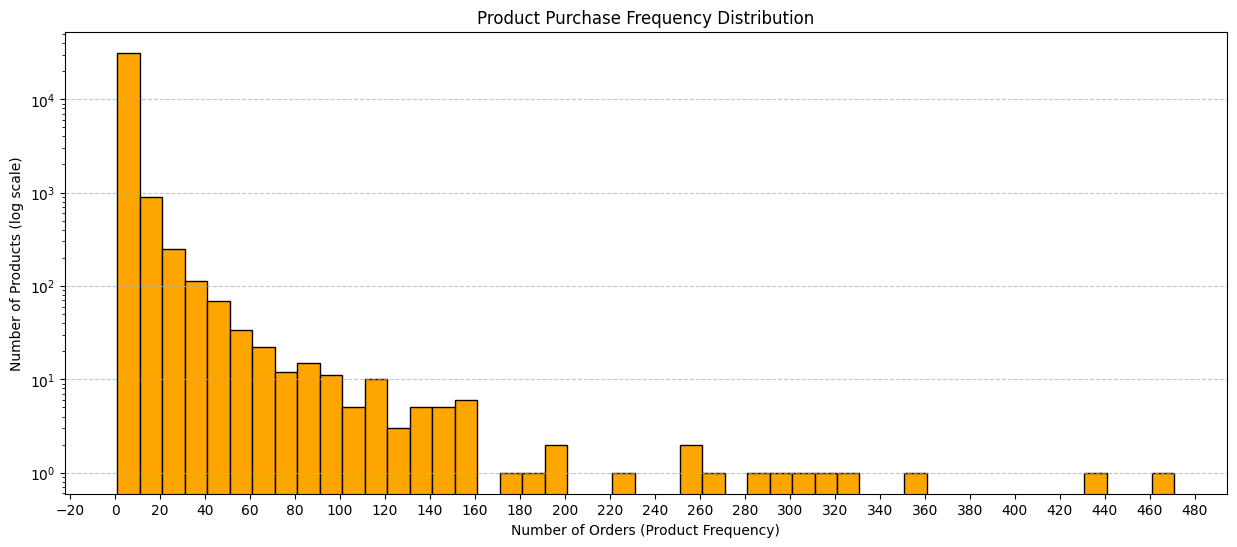

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

plt.figure(figsize=(15,6))
bin_width = 10
bins = np.arange(min(item_freq), max(item_freq) + bin_width, bin_width)
plt.hist(item_freq, bins=bins, edgecolor='black', color='orange')
plt.yscale('log')  # since most products are rare, log scale shows the spread better
plt.xlabel('Number of Orders (Product Frequency)')
plt.ylabel('Number of Products (log scale)')
plt.title('Product Purchase Frequency Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# More x-axis marks every 5 purchases
plt.gca().xaxis.set_major_locator(MultipleLocator(20))

plt.show()


In [15]:
orders_cut = orders[orders.isin(item_freq.index[item_freq >= 20]).values]
orders_cut['product_id'].value_counts()

,count
product_id,
99a4788cb24856965c36a24e339b6058,467
aca2eb7d00ea1a7b8ebd4e68314663af,431
422879e10f46682990de24d770e7f83d,352
d1c427060a0f73f6b889a5c7c61f2ac4,323
389d119b48cf3043d311335e499d9c6b,311
...,...
612c7f49d1026f7beded75464b574f81,20
7b35ccd93a2184646c03b70326626923,20
f889fb87b505b73de10c18b93352469f,20


In [16]:
orders_cut.shape

(29413, 3)

## Products

In [17]:
products_raw.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0




*   **product_id** - unique product identifier
*   **product_category_name** - root category of product, in Portuguese
*   **product_name_length** - number of characters extracted from the product name
*   **product_description_length** - number of characters extracted from the product description
*   **product_photos_qty** - number of product published photos
*   **product_weight_g** - product weight measured in grams
*   **product_length_cm** - product length measured in centimeters
*   **product_height_cm** - product height measured in centimeters
*   **product_width_cm** - product width measured in centimeters


In [18]:
products_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Some products have missing values in the `product_category_name` column. These rows will be dropped to ensure all products are assigned to a valid category.

In [19]:
products_raw.loc[products_raw.product_category_name.isnull()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [20]:
distinct_categories = pd.Series(products_raw['product_category_name'].dropna().unique())  #does not count NaN
print(f"{len(distinct_categories)} different categories in total")

73 different categories in total


In [21]:
products = products_raw.dropna(subset=['product_category_name'])
products.shape

(32341, 9)

## Products Translation

Since the product categories are in Portuguese, a translation table is used to map each category to its English equivalent for easier interpretation in the analysis.

In [22]:
products_transl_raw.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor




*   **product_category_name** - category name in Portuguese
*   **product_category_name_english** - category name in English





In [23]:
products_transl_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


No missing value there.

In [24]:
len(products_transl_raw['product_category_name'].unique())

71

The number of categories in the translation table is smaller than in the products table. Let's investigate the cause of this mismatch.

In [25]:
s1=set(distinct_categories)
s2=set(products_transl_raw['product_category_name'])
# Differences
only_in_s1 = s1 - s2
only_in_s2 = s2 - s1

print("Values in distinct_categories but not in products_transl_raw['product_category_name']:")
print(only_in_s1)

print("\nValues in products_transl_raw['product_category_name'] but not in distinct_categories:")
print(only_in_s2)

Values in distinct_categories but not in products_transl_raw['product_category_name']:
{'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

Values in products_transl_raw['product_category_name'] but not in distinct_categories:
set()


Let's add the two missing categories to the translation table so that all categories from the products dataset have a corresponding translation.

In [26]:
new_rows = pd.DataFrame({
    'product_category_name': [
        'portateis_cozinha_e_preparadores_de_alimentos',
        'pc_gamer'
    ],
    'product_category_name_english': [
        'portable_kitchen_appliances_and_food_processors',
        'pc_gamer'
    ]
})

# Append to the DataFrame
products_transl = pd.concat([products_transl_raw, new_rows], ignore_index=True)

In [27]:
display(products_transl.tail())

,product_category_name,product_category_name_english
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
70,seguros_e_servicos,security_and_services
71,portateis_cozinha_e_preparadores_de_alimentos,portable_kitchen_appliances_and_food_processors
72,pc_gamer,pc_gamer


## Final table

Now we merge the translated category names into the main products table to include both Portuguese and English category names.

In [28]:
products_with_trans = products.merge(
    products_transl,
    on='product_category_name',
    how='left'
)
products_with_trans.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [29]:
df = orders.merge(
    products_with_trans[['product_id', 'product_category_name_english']],
    on='product_id',
    how='left'
)

In [30]:
df.head()

,order_id,product_id,quantity,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,pet_shop
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,garden_tools


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_id                       102425 non-null  object
 1   product_id                     102425 non-null  object
 2   quantity                       102425 non-null  int64 
 3   product_category_name_english  100965 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


We will drop products that do not have a category name.

In [32]:
df = df.dropna(subset=['product_category_name_english'])
df.shape

(100965, 4)

In [33]:
df['product_category_name_english'].value_counts()

,count
product_category_name_english,
bed_bath_table,10160
health_beauty,9022
sports_leisure,7858
computers_accessories,6887
furniture_decor,6781
...,...
la_cuisine,13
cds_dvds_musicals,12
pc_gamer,8


In [ ]:
df.to_csv('olist_orders',index=False)

In [34]:
orders = df
# Count distinct categories per order
categories_per_order = (
    orders.groupby("order_id")["product_category_name_english"]
    .nunique()
    .reset_index(name="num_categories")
)

# Filter only orders with 2 or more categories
multi_category_orders = categories_per_order[categories_per_order["num_categories"] > 1]

# Results
total_orders = orders["order_id"].nunique()
multi_orders_count = multi_category_orders["order_id"].nunique()
share = multi_orders_count / total_orders * 100

print("Total orders:", total_orders)
print("Orders with multiple categories:", multi_orders_count)
print(f"Share of multi-category orders: {share:.2f}%")

Total orders: 97277
Orders with multiple categories: 727
Share of multi-category orders: 0.75%
